# 🌍 Global Earthquake-Tsunami Risk Assessment: ML Prediction & Geographic Analysis

## 📌 Project Overview

This comprehensive data science project analyzes **782 major earthquakes** worldwide to predict tsunami risk using advanced machine learning models. By combining geographic clustering, feature engineering, and three predictive algorithms, this analysis provides actionable insights for early warning systems.

**Best Model Accuracy: 85.71% (Random Forest)**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

In [2]:
df = pd.read_csv('/kaggle/input/global-earthquake-tsunami-risk-assessment-dataset/earthquake_data_tsunami.csv')

print(f"\nDataset Loaded Successfully!")
print(f"   • Total Records: {len(df):,}")
print(f"   • Total Features: {len(df.columns)}")
print(f"   • Memory Usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")



Dataset Loaded Successfully!
   • Total Records: 782
   • Total Features: 13
   • Memory Usage: 79.55 KB


In [3]:
df.isnull().sum()

magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
magnitude,782.0,6.941125,0.445514,6.5000,6.60000,6.8000,7.1000,9.1000
cdi,782.0,4.333760,3.169939,0.0000,0.00000,5.0000,7.0000,9.0000
mmi,782.0,5.964194,1.462724,1.0000,5.00000,6.0000,7.0000,9.0000
sig,782.0,870.108696,322.465367,650.0000,691.00000,754.0000,909.7500,2910.0000
nst,782.0,230.250639,250.188177,0.0000,0.00000,140.0000,445.0000,934.0000
dmin,782.0,1.325757,2.218805,0.0000,0.00000,0.0000,1.8630,17.6540
gap,782.0,25.038990,24.225067,0.0000,14.62500,20.0000,30.0000,239.0000
depth,782.0,75.883199,137.277078,2.7000,14.00000,26.2950,49.7500,670.8100
latitude,782.0,3.538100,27.303429,-61.8484,-14.59560,-2.5725,24.6545,71.6312
longitude,782.0,52.609199,117.898886,-179.9680,-71.66805,109.4260,148.9410,179.6620


In [5]:
# DATA PREPROCESSING & FEATURE ENGINEERING

df_processed = df.copy()

# Feature Engineering
print("Creating new features...")

# 1. Earthquake severity categories
df_processed['magnitude_category'] = pd.cut(df_processed['magnitude'], 
                                            bins=[0, 3, 4, 5, 6, 7, 10],
                                            labels=['Minor', 'Small', 'Light', 'Moderate', 'Strong', 'Major'])

# 2. Depth categories (shallow earthquakes are more dangerous)
df_processed['depth_category'] = pd.cut(df_processed['depth'], 
                                        bins=[0, 70, 300, 700],
                                        labels=['Shallow', 'Intermediate', 'Deep'])

# 3. Risk score (combined metric)
df_processed['risk_score'] = (
    (df_processed['magnitude'] / 10) * 0.35 +
    (100 - df_processed['depth'] / 7) * 0.25 +
    (df_processed['sig'] / 1000) * 0.20 +
    (df_processed['mmi'] / 12) * 0.20
) * 100

df_processed['risk_level'] = pd.cut(df_processed['risk_score'], 
                                    bins=[0, 20, 40, 60, 80, 100],
                                    labels=['Very Low', 'Low', 'Moderate', 'High', 'Critical'])

# 4. Season
df_processed['season'] = df_processed['Month'].apply(
    lambda x: 'Winter' if x in [12, 1, 2] else 
              'Spring' if x in [3, 4, 5] else 
              'Summer' if x in [6, 7, 8] else 'Fall'
)

# 5. Time-based features
df_processed['is_recent'] = (df_processed['Year'] >= 2020).astype(int)

print("Features created: magnitude_category, depth_category, risk_score, risk_level, season")

print("\nNEW FEATURES DISTRIBUTION:")
print(f" • Magnitude Categories:\n{df_processed['magnitude_category'].value_counts().sort_index()}")
print(f"\n • Depth Categories:\n{df_processed['depth_category'].value_counts()}")
print(f"\n  • Risk Levels:\n{df_processed['risk_level'].value_counts()}")
print(f"\n  • Tsunami Events: {df_processed['tsunami'].sum()} ({df_processed['tsunami'].sum()/len(df_processed)*100:.2f}%)")


Creating new features...
Features created: magnitude_category, depth_category, risk_score, risk_level, season

NEW FEATURES DISTRIBUTION:
 • Magnitude Categories:
magnitude_category
Minor         0
Small         0
Light         0
Moderate      0
Strong      548
Major       234
Name: count, dtype: int64

 • Depth Categories:
depth_category
Shallow         619
Intermediate    111
Deep             52
Name: count, dtype: int64

  • Risk Levels:
risk_level
Very Low    0
Low         0
Moderate    0
High        0
Critical    0
Name: count, dtype: int64

  • Tsunami Events: 304 (38.87%)


EDA visualization saved: '01_eda_analysis.png'


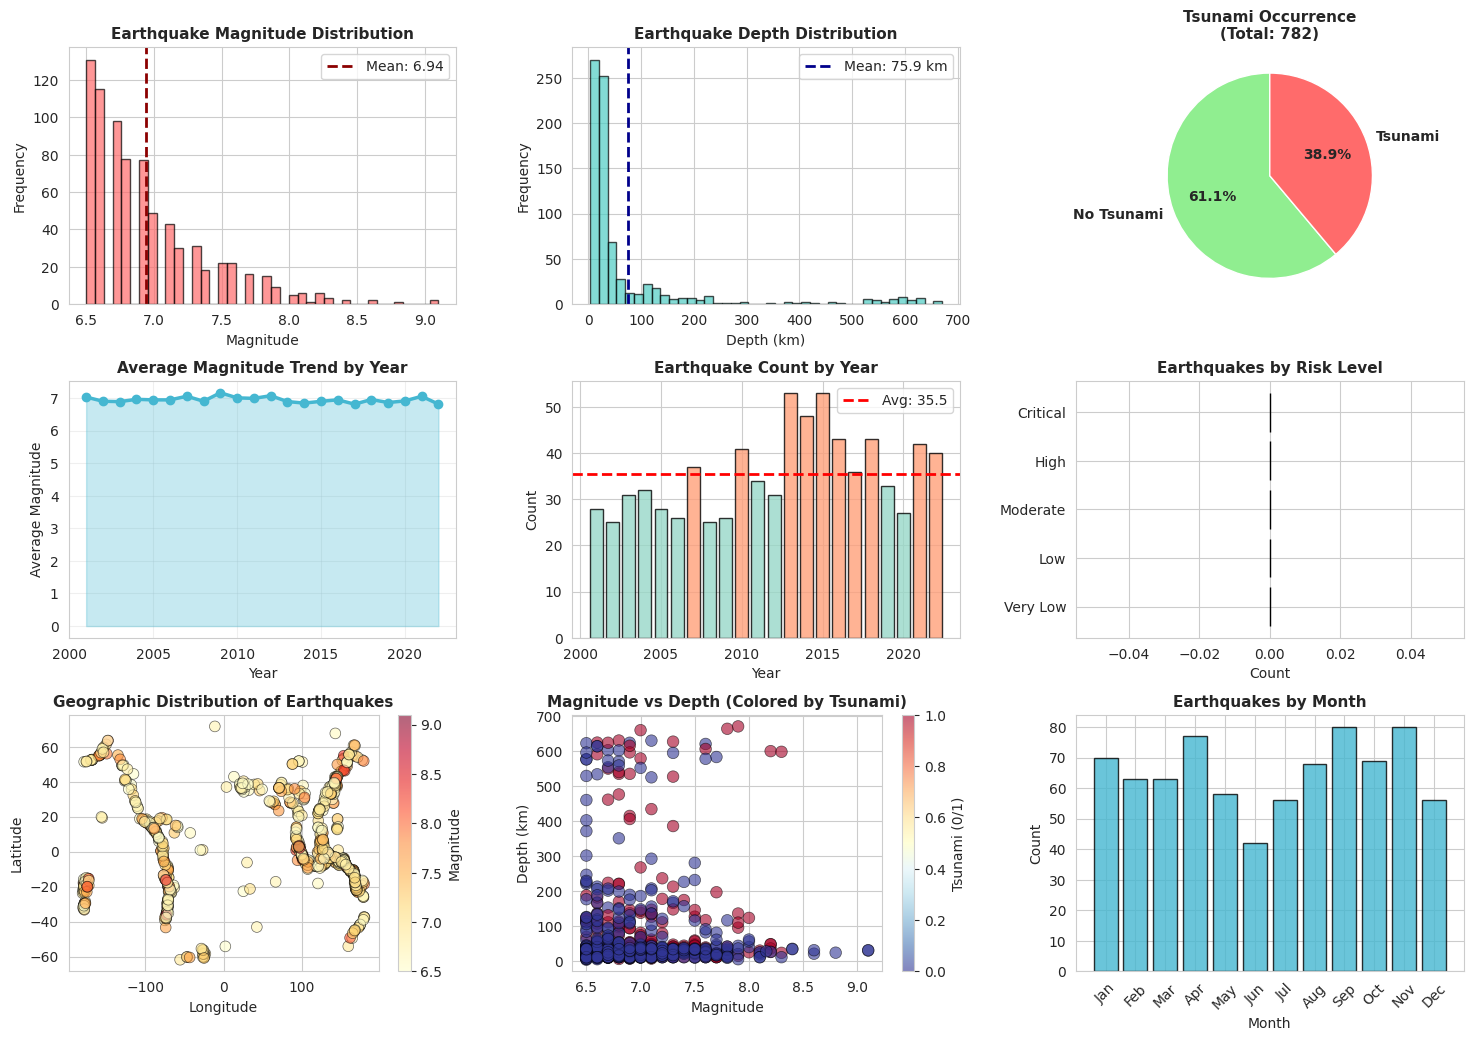

In [6]:
# EXPLORATORY DATA ANALYSIS - VISUALIZATIONS
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Magnitude Distribution
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(df_processed['magnitude'], bins=40, color='#FF6B6B', edgecolor='black', alpha=0.7)
ax1.axvline(df_processed['magnitude'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {df_processed["magnitude"].mean():.2f}')
ax1.set_title('Earthquake Magnitude Distribution', fontweight='bold', fontsize=11)
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Frequency')
ax1.legend()

# 2. Depth Distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(df_processed['depth'], bins=40, color='#4ECDC4', edgecolor='black', alpha=0.7)
ax2.axvline(df_processed['depth'].mean(), color='darkblue', linestyle='--', linewidth=2, label=f'Mean: {df_processed["depth"].mean():.1f} km')
ax2.set_title('Earthquake Depth Distribution', fontweight='bold', fontsize=11)
ax2.set_xlabel('Depth (km)')
ax2.set_ylabel('Frequency')
ax2.legend()

# 3. Tsunami Distribution
ax3 = fig.add_subplot(gs[0, 2])
tsunami_counts = df_processed['tsunami'].value_counts()
colors_pie = ['#90EE90', '#FF6B6B']
ax3.pie(tsunami_counts, labels=['No Tsunami', 'Tsunami'], autopct='%1.1f%%', colors=colors_pie, startangle=90, textprops={'fontweight': 'bold'})
ax3.set_title(f'Tsunami Occurrence\n(Total: {tsunami_counts.sum()})', fontweight='bold', fontsize=11)

# 4. Magnitude by Year
ax4 = fig.add_subplot(gs[1, 0])
yearly_mag = df_processed.groupby('Year')['magnitude'].agg(['mean', 'count'])
ax4.plot(yearly_mag.index, yearly_mag['mean'], marker='o', linewidth=2.5, markersize=6, color='#45B7D1')
ax4.fill_between(yearly_mag.index, yearly_mag['mean'], alpha=0.3, color='#45B7D1')
ax4.set_title('Average Magnitude Trend by Year', fontweight='bold', fontsize=11)
ax4.set_xlabel('Year')
ax4.set_ylabel('Average Magnitude')
ax4.grid(True, alpha=0.3)

# 5. Earthquakes Count by Year
ax5 = fig.add_subplot(gs[1, 1])
yearly_count = df_processed.groupby('Year').size()
colors_bar = ['#FFA07A' if yearly_count[year] > yearly_count.mean() else '#98D8C8' for year in yearly_count.index]
ax5.bar(yearly_count.index, yearly_count.values, color=colors_bar, edgecolor='black', alpha=0.8)
ax5.axhline(yearly_count.mean(), color='red', linestyle='--', linewidth=2, label=f'Avg: {yearly_count.mean():.1f}')
ax5.set_title('Earthquake Count by Year', fontweight='bold', fontsize=11)
ax5.set_xlabel('Year')
ax5.set_ylabel('Count')
ax5.legend()

# 6. Risk Level Distribution
ax6 = fig.add_subplot(gs[1, 2])
risk_counts = df_processed['risk_level'].value_counts()
risk_colors = {'Very Low': '#90EE90', 'Low': '#FFD700', 'Moderate': '#FFA500', 'High': '#FF6347', 'Critical': '#8B0000'}
colors_risk = [risk_colors.get(cat, '#999999') for cat in risk_counts.index]
ax6.barh(risk_counts.index, risk_counts.values, color=colors_risk, edgecolor='black')
ax6.set_title('Earthquakes by Risk Level', fontweight='bold', fontsize=11)
ax6.set_xlabel('Count')

# 7. Geographic Distribution
ax7 = fig.add_subplot(gs[2, 0])
scatter = ax7.scatter(df_processed['longitude'], df_processed['latitude'], 
                      c=df_processed['magnitude'], cmap='YlOrRd', s=60, alpha=0.6, edgecolors='black', linewidth=0.5)
ax7.set_title('Geographic Distribution of Earthquakes', fontweight='bold', fontsize=11)
ax7.set_xlabel('Longitude')
ax7.set_ylabel('Latitude')
cbar = plt.colorbar(scatter, ax=ax7)
cbar.set_label('Magnitude')

# 8. Magnitude vs Depth
ax8 = fig.add_subplot(gs[2, 1])
scatter2 = ax8.scatter(df_processed['magnitude'], df_processed['depth'], 
                       c=df_processed['tsunami'], cmap='RdYlBu_r', s=70, alpha=0.6, edgecolors='black', linewidth=0.5)
ax8.set_title('Magnitude vs Depth (Colored by Tsunami)', fontweight='bold', fontsize=11)
ax8.set_xlabel('Magnitude')
ax8.set_ylabel('Depth (km)')
cbar2 = plt.colorbar(scatter2, ax=ax8)
cbar2.set_label('Tsunami (0/1)')

# 9. Monthly Distribution
ax9 = fig.add_subplot(gs[2, 2])
monthly_data = df_processed.groupby('Month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax9.bar(monthly_data.index, monthly_data.values, color='#45B7D1', edgecolor='black', alpha=0.8)
ax9.set_title('Earthquakes by Month', fontweight='bold', fontsize=11)
ax9.set_xlabel('Month')
ax9.set_ylabel('Count')
ax9.set_xticks(range(1, 13))
ax9.set_xticklabels(month_names, rotation=45)

plt.savefig('01_eda_analysis.png', dpi=300, bbox_inches='tight')
print("EDA visualization saved: '01_eda_analysis.png'")
plt.show()


Correlation visualization saved: '02_correlation_analysis.png'


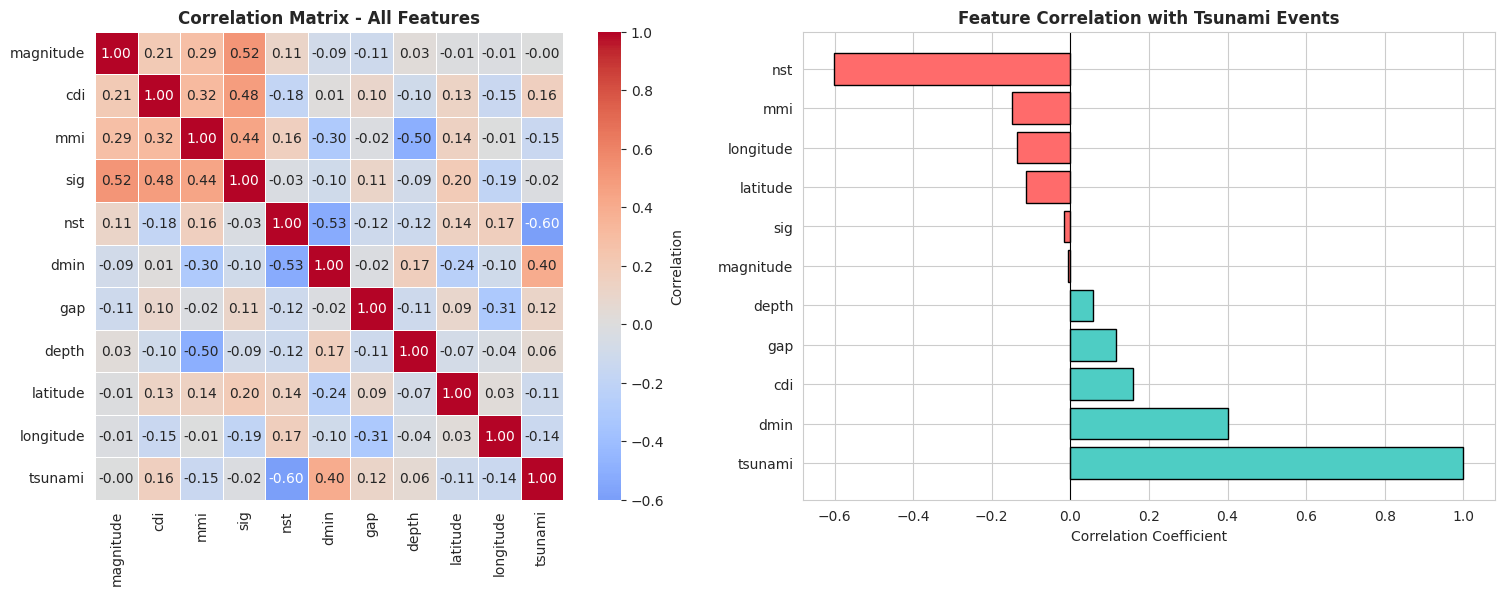


TOP CORRELATIONS WITH TSUNAMI EVENTS:
tsunami      1.000000
dmin         0.400752
cdi          0.160266
gap          0.116360
depth        0.056814
magnitude   -0.004726
sig         -0.015500
latitude    -0.113209
longitude   -0.136778
mmi         -0.147363
nst         -0.600231
Name: tsunami, dtype: float64


In [7]:
 # CORRELATION ANALYSIS
numerical_features = ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'tsunami']
corr_matrix = df_processed[numerical_features].corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, ax=axes[0], cbar_kws={'label': 'Correlation'}, linewidths=0.5)
axes[0].set_title('Correlation Matrix - All Features', fontweight='bold', fontsize=12)

# Tsunami correlation
tsunami_corr = corr_matrix['tsunami'].sort_values(ascending=False)
colors_corr = ['#4ECDC4' if x > 0 else '#FF6B6B' for x in tsunami_corr.values]
axes[1].barh(range(len(tsunami_corr)), tsunami_corr.values, color=colors_corr, edgecolor='black')
axes[1].set_yticks(range(len(tsunami_corr)))
axes[1].set_yticklabels(tsunami_corr.index)
axes[1].set_title('Feature Correlation with Tsunami Events', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Correlation Coefficient')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.savefig('02_correlation_analysis.png', dpi=300, bbox_inches='tight')
print("Correlation visualization saved: '02_correlation_analysis.png'")
plt.show()

print("\nTOP CORRELATIONS WITH TSUNAMI EVENTS:")
print(tsunami_corr)

Risk assessment visualization saved: '03_risk_assessment.png'


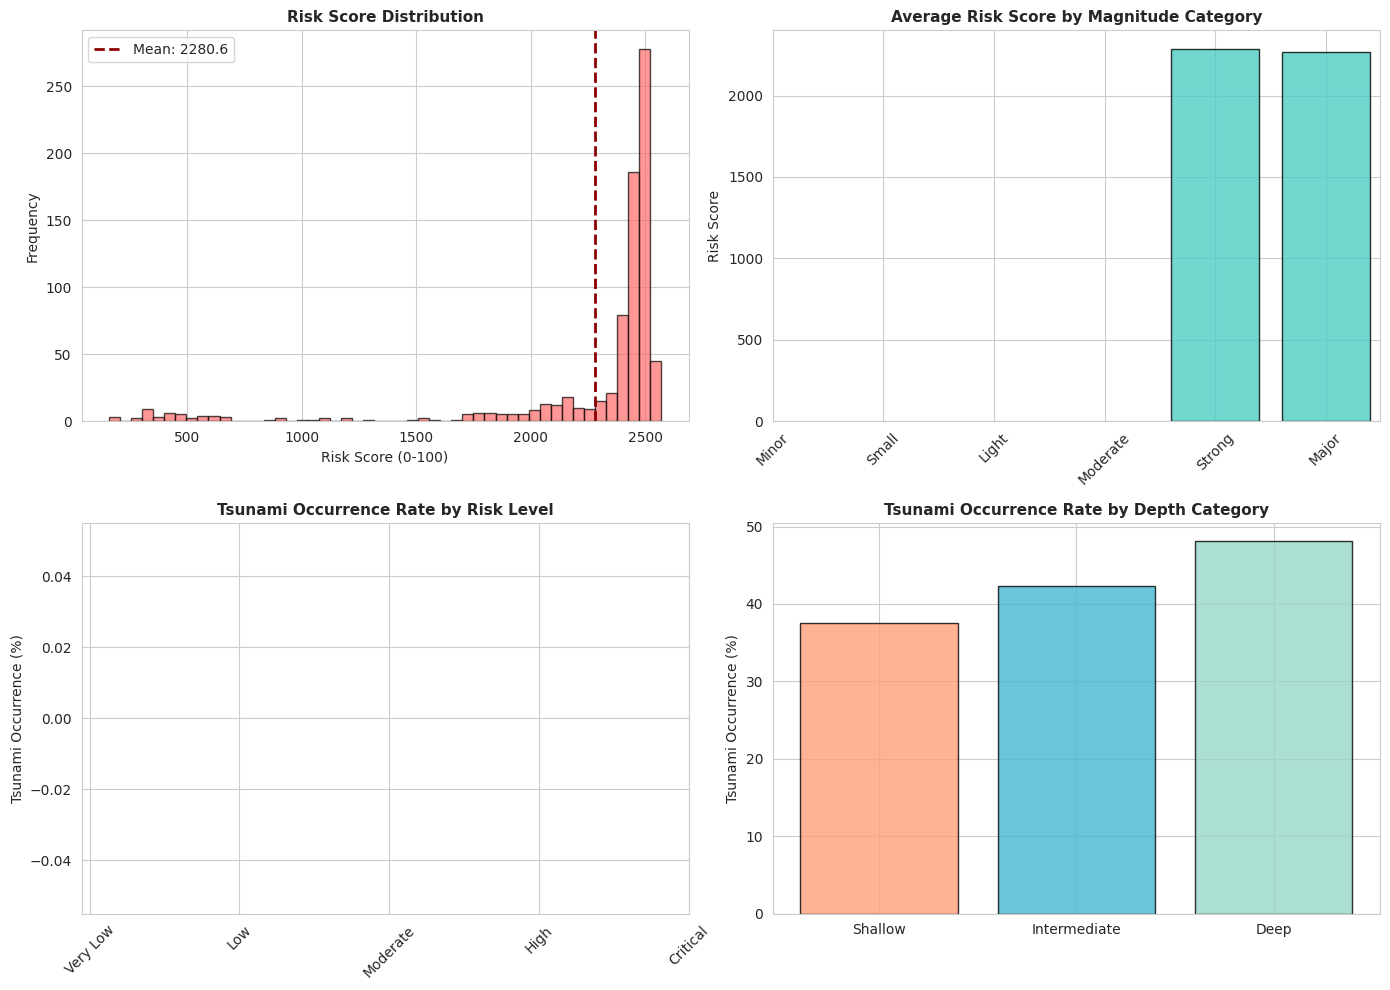


RISK PROFILE STATISTICS:


In [8]:
# RISK ASSESSMENT & PROFILING
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Risk score distribution
axes[0, 0].hist(df_processed['risk_score'], bins=50, color='#FF6B6B', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_processed['risk_score'].mean(), color='darkred', linestyle='--', linewidth=2, 
                    label=f'Mean: {df_processed["risk_score"].mean():.1f}')
axes[0, 0].set_title('Risk Score Distribution', fontweight='bold', fontsize=11)
axes[0, 0].set_xlabel('Risk Score (0-100)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Risk by magnitude category
risk_by_mag = df_processed.groupby('magnitude_category')['risk_score'].mean()
axes[0, 1].bar(range(len(risk_by_mag)), risk_by_mag.values, color='#4ECDC4', edgecolor='black', alpha=0.8)
axes[0, 1].set_xticks(range(len(risk_by_mag)))
axes[0, 1].set_xticklabels(risk_by_mag.index, rotation=45)
axes[0, 1].set_title('Average Risk Score by Magnitude Category', fontweight='bold', fontsize=11)
axes[0, 1].set_ylabel('Risk Score')

# Tsunami occurrence by risk level
tsunami_by_risk = df_processed.groupby('risk_level')['tsunami'].mean() * 100
risk_colors_list = ['#90EE90', '#FFD700', '#FFA500', '#FF6347', '#8B0000']
axes[1, 0].bar(range(len(tsunami_by_risk)), tsunami_by_risk.values, color=risk_colors_list, edgecolor='black', alpha=0.8)
axes[1, 0].set_xticks(range(len(tsunami_by_risk)))
axes[1, 0].set_xticklabels(tsunami_by_risk.index, rotation=45)
axes[1, 0].set_title('Tsunami Occurrence Rate by Risk Level', fontweight='bold', fontsize=11)
axes[1, 0].set_ylabel('Tsunami Occurrence (%)')

# Tsunami by depth category
tsunami_by_depth = df_processed.groupby('depth_category')['tsunami'].mean() * 100
axes[1, 1].bar(range(len(tsunami_by_depth)), tsunami_by_depth.values, color=['#FFA07A', '#45B7D1', '#98D8C8'], 
               edgecolor='black', alpha=0.8)
axes[1, 1].set_xticks(range(len(tsunami_by_depth)))
axes[1, 1].set_xticklabels(tsunami_by_depth.index)
axes[1, 1].set_title('Tsunami Occurrence Rate by Depth Category', fontweight='bold', fontsize=11)
axes[1, 1].set_ylabel('Tsunami Occurrence (%)')

plt.tight_layout()
plt.savefig('03_risk_assessment.png', dpi=300, bbox_inches='tight')
print("Risk assessment visualization saved: '03_risk_assessment.png'")
plt.show()

print("\nRISK PROFILE STATISTICS:")
for risk_level in ['Very Low', 'Low', 'Moderate', 'High', 'Critical']:
    subset = df_processed[df_processed['risk_level'] == risk_level]
    if len(subset) > 0:
        print(f"\n{risk_level}:")
        print(f"   • Count: {len(subset)}")
        print(f"   • Avg Magnitude: {subset['magnitude'].mean():.2f}")
        print(f"   • Avg Depth: {subset['depth'].mean():.1f} km")
        print(f"   • Tsunami Events: {subset['tsunami'].sum()} ({subset['tsunami'].mean()*100:.2f}%)")


Geographic clustering visualization saved: '04_geographic_clustering.png'


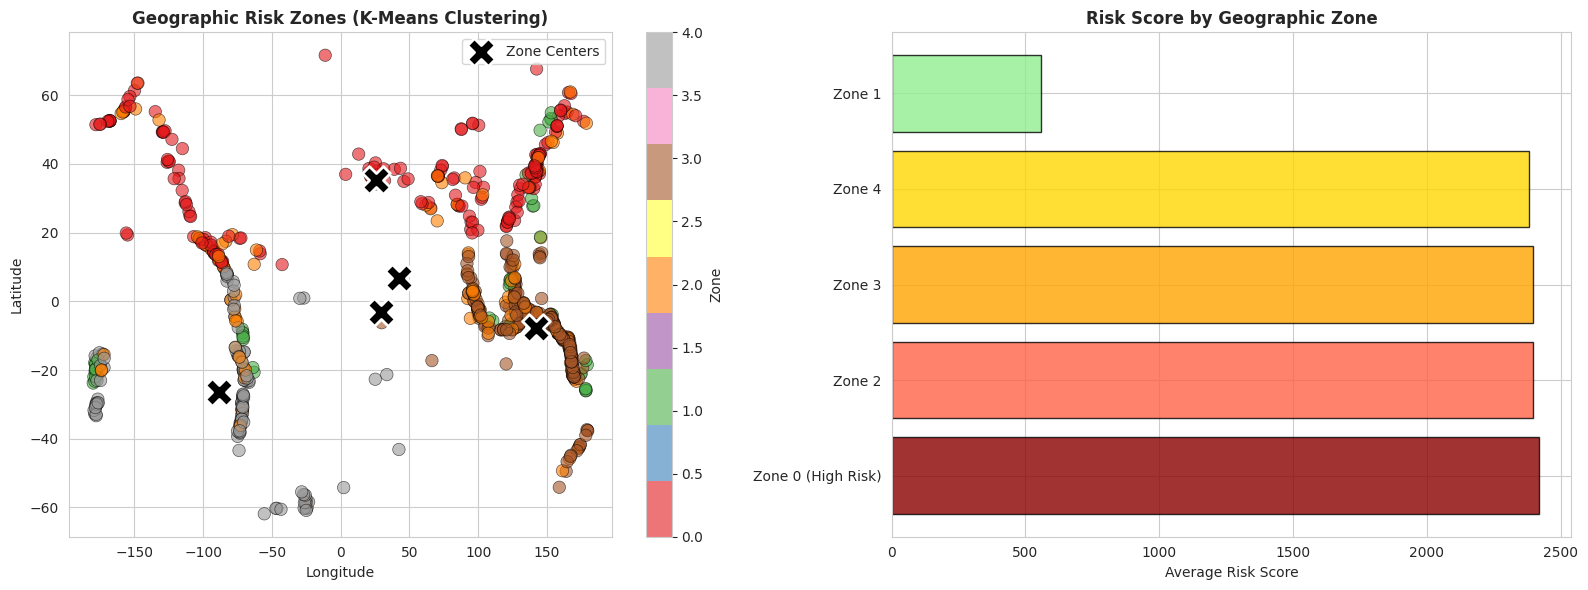


ZONE ANALYSIS:

🔴 ZONE 0:
   • Total Events: 215
   • Avg Magnitude: 6.77
   • Avg Depth: 37.5 km
   • Avg Latitude: 35.24
   • Avg Longitude: 25.69
   • Tsunami Events: 74 (34.42%)
   • Risk Score: 2419.1/100

🔴 ZONE 1:
   • Total Events: 51
   • Avg Magnitude: 6.96
   • Avg Depth: 556.2 km
   • Avg Latitude: -3.16
   • Avg Longitude: 29.59
   • Tsunami Events: 25 (49.02%)
   • Risk Score: 558.9/100

🔴 ZONE 2:
   • Total Events: 113
   • Avg Magnitude: 7.77
   • Avg Depth: 46.1 km
   • Avg Latitude: 6.79
   • Avg Longitude: 42.56
   • Tsunami Events: 38 (33.63%)
   • Risk Score: 2398.1/100

🔴 ZONE 3:
   • Total Events: 282
   • Avg Magnitude: 6.79
   • Avg Depth: 42.6 km
   • Avg Latitude: -7.84
   • Avg Longitude: 141.75
   • Tsunami Events: 104 (36.88%)
   • Risk Score: 2396.1/100

🔴 ZONE 4:
   • Total Events: 121
   • Avg Magnitude: 6.81
   • Avg Depth: 47.0 km
   • Avg Latitude: -26.48
   • Avg Longitude: -88.22
   • Tsunami Events: 63 (52.07%)
   • Risk Score: 2381.5/100


In [9]:
 # GEOGRAPHIC CLUSTERING - HIGH-RISK ZONES
# Prepare data for clustering
X_cluster = df_processed[['latitude', 'longitude', 'magnitude', 'depth']].values
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_processed['zone'] = kmeans.fit_predict(X_cluster_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Geographic zones
scatter = axes[0].scatter(df_processed['longitude'], df_processed['latitude'], 
                          c=df_processed['zone'], cmap='Set1', s=80, alpha=0.6, 
                          edgecolors='black', linewidth=0.5)
axes[0].scatter(scaler_cluster.inverse_transform(kmeans.cluster_centers_)[:, 1],
                scaler_cluster.inverse_transform(kmeans.cluster_centers_)[:, 0],
                c='black', marker='X', s=400, edgecolors='white', linewidth=2, label='Zone Centers')
axes[0].set_title('Geographic Risk Zones (K-Means Clustering)', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].legend()
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Zone')

# Zone statistics
zone_stats = df_processed.groupby('zone').agg({
    'magnitude': 'mean',
    'depth': 'mean',
    'tsunami': ['sum', 'mean'],
    'risk_score': 'mean'
}).round(2)

zone_threat = df_processed.groupby('zone')['risk_score'].mean().sort_values(ascending=False)
zone_colors = ['#8B0000', '#FF6347', '#FFA500', '#FFD700', '#90EE90']
axes[1].barh(range(len(zone_threat)), zone_threat.values, color=zone_colors, edgecolor='black', alpha=0.8)
axes[1].set_yticks(range(len(zone_threat)))
axes[1].set_yticklabels([f'Zone {int(z)} (High Risk)' if i == 0 else f'Zone {int(z)}' 
                          for i, z in enumerate(zone_threat.index)])
axes[1].set_title('Risk Score by Geographic Zone', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Average Risk Score')

plt.tight_layout()
plt.savefig('04_geographic_clustering.png', dpi=300, bbox_inches='tight')
print("Geographic clustering visualization saved: '04_geographic_clustering.png'")
plt.show()

print("\nZONE ANALYSIS:")
for zone in sorted(df_processed['zone'].unique()):
    zone_data = df_processed[df_processed['zone'] == zone]
    print(f"\n🔴 ZONE {zone}:")
    print(f"   • Total Events: {len(zone_data)}")
    print(f"   • Avg Magnitude: {zone_data['magnitude'].mean():.2f}")
    print(f"   • Avg Depth: {zone_data['depth'].mean():.1f} km")
    print(f"   • Avg Latitude: {zone_data['latitude'].mean():.2f}")
    print(f"   • Avg Longitude: {zone_data['longitude'].mean():.2f}")
    print(f"   • Tsunami Events: {zone_data['tsunami'].sum()} ({zone_data['tsunami'].mean()*100:.2f}%)")
    print(f"   • Risk Score: {zone_data['risk_score'].mean():.1f}/100")
